# Generating Synthetic Data preserving One-and Two-Way Marginals via Covariance

In [82]:
import numpy as np
import pandas as pd
import pygwalker as pyg
import seaborn as sb
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from sklearn.preprocessing import normalize


## Initi
def generateSyntheticRow(mean, L, dim=2):
    y = [[np.random.normal(0)]]*dim
    row = (np.matmul(L, y) + mean)
    return row.sum(axis=1) \
        .reshape(-1,1) # transposing it

def generateSimpleNetwork(sampleSize, px=[0.1,0.9], py=[[.2,.8],[.2,.8]]):
    bn=gum.fastBN("x->y")
    bn.cpt("x").fillWith(px)
    bn.cpt("y")[:]=py
    ie=gum.LazyPropagation(bn)
    ie.makeInference()
    ie.posterior("x")
    bn.cpt("y")
    g=gum.BNDatabaseGenerator(bn)
    g.setRandomVarOrder()
    g.drawSamples(sampleSize,{})
    df3 = g.to_pandas()
    print(df3.astype("float32").mean().to_numpy())
    print(df3.corr(numeric_only=False))
    return bn, df3

In [ ]:
# Independent
#n_samples= 1000

#independent_features = np.random.rand(2, n_samples)

## Dependent (use noise create 4 dependent on the first)
#base = np.random.rand(2, n_samples)
#noise = np.random.normal(0, 0.1, size=(2, n_samples))
#dependent_features = np.hstack((base, base + noise))
#dataset = np.hstack((independent_features, dependent_features))

#print(dataset)
#np.cov(dataset)

In [24]:
## Generate Data with correlations from a Bayesan Network
## Not necessarily positive semidefinite

bn, df3 = generateSimpleNetwork(100000)
gnb.flow.row(bn,gnb.getInference(bn, evs ={'x':0}))
gnb.flow.row(bn,gnb.getInference(bn, evs ={'x':1}))
gnb.flow.row(bn,gnb.getInference(bn, evs ={}))



[1.      0.30176]
    x    y
x NaN  NaN
y NaN  1.0


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[0.7955 0.897 ]
          y         x
y  1.000000  0.000298
x  0.000298  1.000000
[[0.13932091964064222], [0.13932091964064222]]
[[-0.2189893778858142], [-0.2189893778858142]]
[[0.1816576438983638], [0.1816576438983638]]
[[0.4557901463144385], [0.4557901463144385]]
[[-0.3647485319187095], [-0.3647485319187095]]
[[0.14590078006856755], [0.14590078006856755]]
[[-0.07230694799297892], [-0.07230694799297892]]
[[1.938036926562334], [1.938036926562334]]
[[-1.6133036129790033], [-1.6133036129790033]]
[[2.137578414352011], [2.137578414352011]]
[[-0.4980136814337762], [-0.4980136814337762]]
[[-1.0785253561281885], [-1.0785253561281885]]
[[0.26920544120827117], [0.26920544120827117]]
[[0.3062245962778324], [0.3062245962778324]]
[[-0.91776244899938], [-0.91776244899938]]
[[0.04136612024232625], [0.04136612024232625]]
[[1.3080613220473447], [1.3080613220473447]]
[[-0.5786818479167157], [-0.5786818479167157]]
[[0.4701352949544798], [0.4701352949544798]]
[[0.3793990288202606], [0.3793990288202606]]


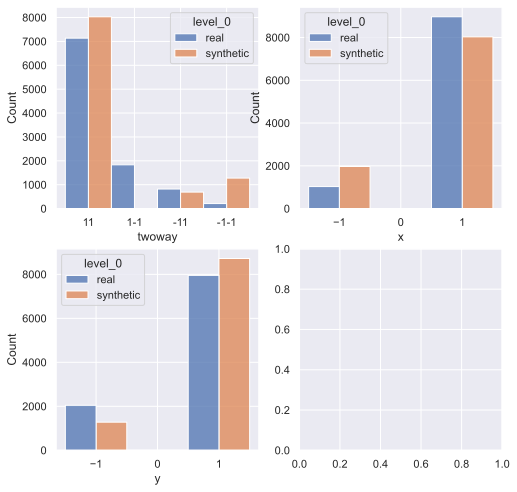

In [103]:
## First tries with uncorrelated data
def mergeDataFrames(realData, synthetic_data):
    df1 = realData \
        .applymap(lambda x: (-1 if int(x) <= 0 else 1))
    df2 = pd.DataFrame(synthetic_data.T, columns=["x","y"]) \
        .applymap(lambda x: (-1 if int(x) <= 0 else 1))
    df1['twoway'] = df1['x'].astype(str) + df1['y'].astype(str)
    df2['twoway'] = df2['x'].astype(str) + df2['y'].astype(str)
    df = pd.concat([df1,df2])
    return df, df1, df2

# Parameterizations
DATA_SIZE, SAMPLE_SIZE, dims = (10000, 10000, 2)
shape = (dims, DATA_SIZE)
bn, realData = generateSimpleNetwork(SAMPLE_SIZE)
mean = realData.astype("float32").mean().to_numpy()
# Computing Sample Strategy
cov = realData.cov(numeric_only=False) # dataframe
L = cholesky(cov)
synthetic_data = np.array(generateSyntheticRow(mean, L))
for i in range(SAMPLE_SIZE-1):
    synthetic_data = np.append(synthetic_data,generateSyntheticRow(mean, L), axis=1)

(df, df1, df2) = mergeDataFrames(realData, synthetic_data)

## Visualization / Graphing
viewdata = pd.concat([df1, df2], axis=0, keys=['real','synthetic']).reset_index(level=[0])
sb.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sb.histplot(data = viewdata, x="twoway", bins = 4, ax=axs[0][0], discrete=True,  hue='level_0', multiple="dodge")
sb.histplot(data = viewdata, x="x", bins = 4, ax=axs[0][1], discrete=True,  hue='level_0', multiple="dodge", label="oneway")
sb.histplot(data = viewdata, x="y", bins = 4, ax=axs[1][0], discrete=True,  hue='level_0', multiple="dodge")

dt = {'names':['x', 'y'], 'formats':[float, float]}
synthetic_data_fresh = np.zeros(SAMPLE_SIZE, dtype=dt)
synthetic_data_fresh['x']= synthetic_data[0]
synthetic_data_fresh['y']= synthetic_data[1]

#print(synthetic_data_fresh.dtype.names)
#sb.relplot(data= synthetic_data_fresh,x='x')

print("real mean x: " + str(df1['x'].mean()))
print("real mean y: " + str(df1['y'].mean()))

## Problems: If there was no sample drawn from the covariance matrix, then there will also be no sample in our resulting matrix

# Simulating Correlated Gaussian


[[1.21184797]
 [1.48831465]]
[0.63140586 0.77545254]
[[0.04273413]
 [1.43979693]]
[0.0296676  0.99955982]
[[0.46713414]
 [1.08989867]]
[0.39394403 0.91913443]
[[2.02365211]
 [2.3945229 ]]
[0.64548065 0.76377663]
[[0.70210816]
 [0.39766719]]
[0.87012534 0.49283048]
[[1.05253102]
 [0.48606894]]
[0.9078657 0.4192611]
[[1.66981639]
 [0.35919515]]
[0.9776369  0.21030003]
[[1.85641756]
 [0.71503695]]
[0.93317199 0.35943016]
[[0.17677858]
 [1.07477481]]
[0.16229892 0.98674164]
[[1.91293236]
 [1.19447547]]
[0.84821889 0.52964584]
[[1.43083747]
 [2.26661431]]
[0.53380405 0.8456082 ]
[[1.68420368]
 [1.77695275]]
[0.6879114  0.72579467]
[[1.73858715]
 [0.4599292 ]]
[0.96674443 0.25574444]
[[-0.12791131]
 [ 1.00363681]]
[-0.12642518  0.99197615]
[[0.59746631]
 [0.23822734]]
[0.92888314 0.37037295]
[[0.96989875]
 [0.91710862]]
[0.72660423 0.68705626]
[[0.89622994]
 [0.60352718]]
[0.82946104 0.55856457]
[[2.07091678]
 [1.68627177]]
[0.77544433 0.63141595]
[[0.37182023]
 [1.07120122]]
[0.32791359 0.9

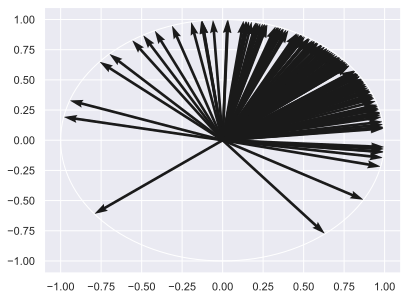

In [16]:
fig, ax = plt.subplots()
circle1 = plt.Circle((0, 0), radius=1, fill=False)
V = np.array([[1,1]])

for i in range(150):
    x = generateSyntheticRow(mean, L)
    print(x)
    norm2 = normalize(x, axis=0).ravel()
    print(norm2)
    X = [0]
    Y = [0]
    U = [norm2[0]]
    V = [norm2[1]]
    plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)

origin = np.array([[0, 0, 0],[0, 0, 0]])
#plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'])
ax.add_patch(circle1)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility

# Parameters of the Gaussian distribution
mean = np.array([0, 0])
cov = np.array([[1, 0], [0, 1]])

# Generate random samples
samples = np.random.multivariate_normal(mean, cov, 1000)

# Plot the samples
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from a 2D Gaussian Distribution')
plt.show()


In [144]:
 from numpy import genfromtxt


,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Smoking_History
Exercise,0.174341,-0.010967,-0.000493,-0.006713,-0.014162,-0.020000,-0.024453,-0.019127
Heart_Disease,-0.010967,0.074314,0.007333,0.007445,0.003549,0.016604,0.019687,0.014429
Skin_Cancer,-0.000493,0.007333,0.087683,0.013202,-0.001543,0.003843,0.018920,0.004773
Other_Cancer,-0.006713,0.007445,0.013202,0.087380,0.001881,0.007029,0.017942,0.007755
Depression,-0.014162,0.003549,-0.001543,0.001881,0.160253,0.005993,0.022840,0.019710
Diabetes,-0.020000,0.016604,0.003843,0.007029,0.005993,0.113148,0.022108,0.009502
Arthritis,-0.024453,0.019687,0.018920,0.017942,0.022840,0.022108,0.220157,0.028382
Smoking_History,-0.019127,0.014429,0.004773,0.007755,0.019710,0.009502,0.028382,0.241085


In [159]:

d = pd.read_csv('./datasets/CVD_cleaned.csv')
columns = ['Exercise','Heart_Disease','Skin_Cancer','Other_Cancer','Depression','Diabetes','Arthritis','Smoking_History']
dsubset = d[columns]*1
dsubset = dsubset.applymap(lambda x: (1 if x == "Yes" else 0))
dsubset.cov()

mean = dsubset.astype("float32").mean().to_numpy()
# Computing Sample Strategy
cov = dsubset.cov(numeric_only=False) # dataframe
L = cholesky(cov)
synthetic_data = np.array(generateSyntheticRow(mean, L, dim=8))

print(mean)
for i in range(300):
    synthetic_data = np.append(synthetic_data,generateSyntheticRow(mean, L, dim=8), axis=1)

synthetic_data = pd.DataFrame(synthetic_data.T, columns=columns) \
    .applymap(lambda x: (-1 if int(x) <= 0 else 1))
dsubset = pd.DataFrame(dsubset) \
    .applymap(lambda x: (-1 if int(x) <= 0 else 1))
#dsubset['Diab-Heart'] = dsubset['Diabetes'].astype(str) + dsubset['Heart_Disease'].astype(str)
#synthetic_data['Diab-Heart'] = synthetic_data['Diabetes'].astype(str) + synthetic_data['Heart_Disease'].astype(str)

#viewdata = pd.concat([dsubset, synthetic_data], axis=0, keys=['real','synthetic']).reset_index(level=[0])
viewdata = pd.concat([synthetic_data], axis=0, keys=['synthetic']).reset_index(level=[0])



[[-0.16500849365034825], [-0.16500849365034825], [-0.16500849365034825], [-0.16500849365034825], [-0.16500849365034825], [-0.16500849365034825], [-0.16500849365034825], [-0.16500849365034825]]
[0.775062   0.0808505  0.09711385 0.09673826 0.20042156 0.1300647
 0.32724524 0.40557674]
[[-0.48105566709456604], [-0.48105566709456604], [-0.48105566709456604], [-0.48105566709456604], [-0.48105566709456604], [-0.48105566709456604], [-0.48105566709456604], [-0.48105566709456604]]
[[-0.7711068123924476], [-0.7711068123924476], [-0.7711068123924476], [-0.7711068123924476], [-0.7711068123924476], [-0.7711068123924476], [-0.7711068123924476], [-0.7711068123924476]]
[[1.25563582533272], [1.25563582533272], [1.25563582533272], [1.25563582533272], [1.25563582533272], [1.25563582533272], [1.25563582533272], [1.25563582533272]]
[[-2.3145017267682206], [-2.3145017267682206], [-2.3145017267682206], [-2.3145017267682206], [-2.3145017267682206], [-2.3145017267682206], [-2.3145017267682206], [-2.314501726768

,level_0,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Smoking_History
0,synthetic,1,1,1,1,1,1,1,1
1,synthetic,-1,1,-1,-1,-1,-1,-1,-1
2,synthetic,-1,-1,-1,-1,-1,-1,-1,-1
3,synthetic,1,1,1,1,1,1,1,1
4,synthetic,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
296,synthetic,1,1,1,1,1,1,1,1
297,synthetic,-1,-1,-1,-1,-1,-1,-1,-1
298,synthetic,1,1,1,1,1,1,1,1
299,synthetic,1,1,1,1,1,1,1,1


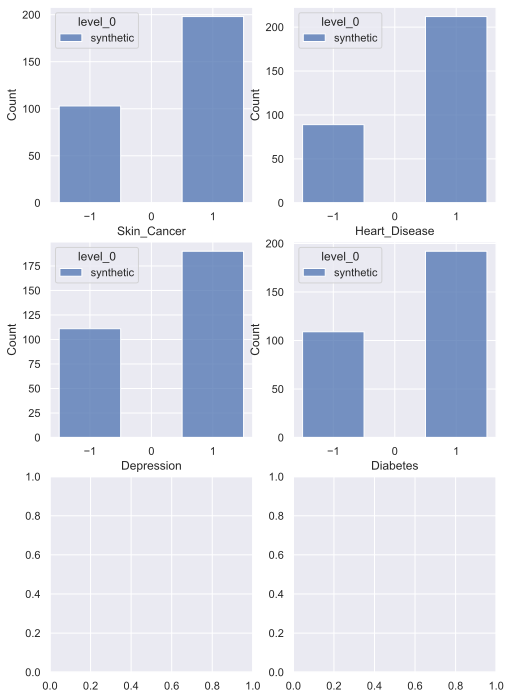

In [164]:
sb.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(8 , 12))
sb.histplot(data = viewdata, x="Skin_Cancer", bins = 4, ax=axs[0][0], discrete=True, hue='level_0', multiple="dodge", label="oneway")
sb.histplot(data = viewdata, x="Heart_Disease", bins = 4, ax=axs[0][1], discrete=True, hue='level_0', multiple="dodge", label="oneway")
sb.histplot(data = viewdata, x="Depression", bins = 4, ax=axs[1][0], discrete=True, hue='level_0', multiple="dodge", label="oneway")
sb.histplot(data = viewdata, x="Diabetes", bins = 4, ax=axs[1][1], discrete=True, hue='level_0', multiple="dodge", label="oneway")
#sb.histplot(data = viewdata, x="Diab-Heart", bins = 4, ax=axs[2][0], discrete=True, hue='level_0', multiple="dodge", label="diab-heart")
#dsubset.describe()
viewdata.describe()
viewdata

In [154]:
viewdata




,level_0,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Smoking_History
0,real,-1,-1,-1,-1,-1,-1,1,1
1,real,-1,1,-1,-1,-1,1,-1,-1
2,real,1,-1,-1,-1,-1,1,-1,-1
3,real,1,1,-1,-1,-1,1,-1,-1
4,real,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...
231279,synthetic,-1,-1,-1,-1,-1,-1,-1,-1
231280,synthetic,1,1,1,1,1,1,-1,-1
231281,synthetic,1,1,1,1,1,1,1,1
231282,synthetic,-1,-1,-1,-1,-1,-1,-1,-1
